# Data Modeling Assignment
***

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import graphviz
import random
from scipy.stats import randint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Data Reading and Extracting
***

In [2]:
# Reading Dataset
ground_water = pd.read_csv("ground_water_quality_2022_post.csv")
ground_water_df = pd.DataFrame(ground_water)
ground_water_df = ground_water_df.dropna()

ground_water_df = ground_water_df.rename(columns = {'NO3 ': 'NO3'})
ground_water_df = ground_water_df.rename(columns = {'RSC  meq  / L': 'RSC'})
numeric = ground_water_df.select_dtypes(include=['number']).columns
nonnumeric = ground_water_df.select_dtypes(exclude=['number']).columns

# Outlier Treatment
for num in numeric:
    Q1 = ground_water_df[num].quantile(0.25)
    Q3 = ground_water_df[num].quantile(0.75)
    IQR = Q3 - Q1
    whisker_width = 1.5
    lower_whisker = Q1 -(whisker_width*IQR)
    upper_whisker = Q3 + (whisker_width*IQR)
    ground_water_df[num]=np.where(ground_water_df[num]>upper_whisker,upper_whisker,np.where(ground_water_df[num]<lower_whisker,lower_whisker,ground_water_df[num]))

In [3]:
# Extracting Chosen Feature to Dataframe
chosen = ['RSC', 'SAR', 'Na', 'E.C', 'TDS', 'HCO3', 'pH', 'mandal', 'village', 'Classification.1']
working_gw_df = ground_water_df[chosen]
working_gw_df = working_gw_df.replace('MR', 'U.S.')

# One-hot encode 'mandal' and 'village' columns separately
mandal_dummies = pd.get_dummies(working_gw_df['mandal'], prefix='mandal')
village_dummies = pd.get_dummies(working_gw_df['village'], prefix='village')

# Concatenate the encoded columns with the original DataFrame
working_gw_df_encoded = pd.concat([working_gw_df.drop(['mandal', 'village'], axis=1), mandal_dummies, village_dummies], axis=1)
working_gw_df_encoded = working_gw_df_encoded.replace('MR', 'U.S.')

# Display the modified DataFrame
working_gw_df_encoded.head()

,RSC,SAR,Na,E.C,TDS,HCO3,pH,Classification.1,mandal_Abdullapurmet,mandal_Achampet,...,village_Yenkiryal,village_Yennaram,village_Yenugonda,village_Yeravaguda,village_Yerkaram,village_Yerrapahad,village_Zafergad,village_Zaptisingaipally,village_kanagala,village_perkit
0,-3.0,1.90,85.0,1065.0,682.0,230.0,8.04,P.S.,False,False,...,False,False,False,False,False,False,False,False,False,False
1,-0.4,0.79,14.0,122.0,78.0,40.0,8.21,P.S.,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2.0,3.31,118.0,945.0,605.0,340.0,7.99,U.S.,False,False,...,False,False,False,False,False,False,False,False,False,False
3,-0.2,2.61,104.0,1028.0,658.0,290.0,8.01,P.S.,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-1.6,1.87,84.0,1110.0,710.0,300.0,8.11,P.S.,False,False,...,False,False,False,False,False,False,False,False,False,False


# Random Forest Algorithm
***

## 1. Random Forest with All Chosen Features

In [4]:
# Splitting Data
random.seed(10)
X = working_gw_df_encoded.drop('Classification.1', axis = 1)
y = working_gw_df_encoded['Classification.1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

In [5]:
# Random Forest
rf = RandomForestClassifier(random_state = 10)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [6]:
# Accuracy Test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9877675840978594


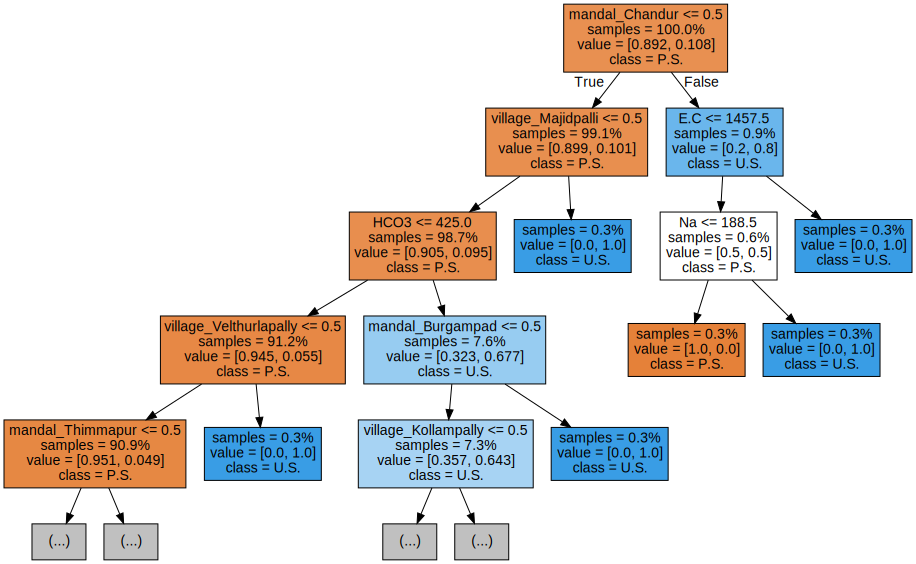

'Random Forest All Features.png'

In [7]:
random.seed(10)
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree, feature_names = X_train.columns, filled = True, max_depth = 4, impurity = False, proportion = True, class_names = ['P.S.', 'U.S.'])
graph = graphviz.Source(dot_data)
display(graph)
graph.render(f'Random Forest All Features', format='png')

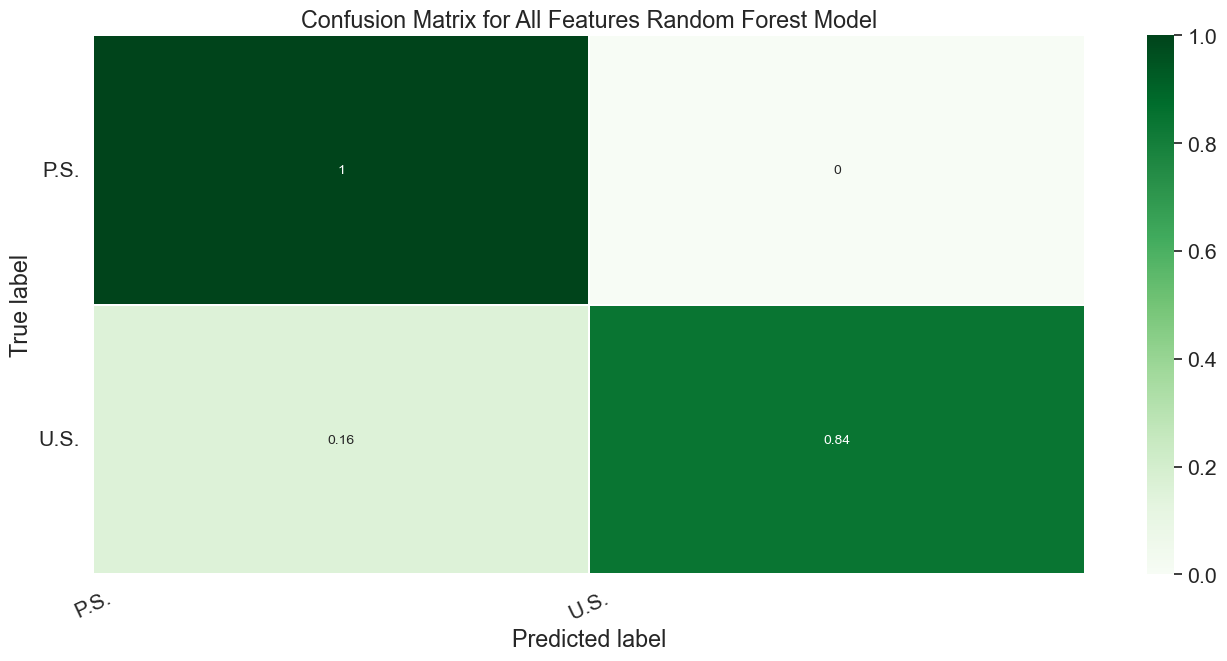

In [8]:
# Confusion Matrix
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis = 1)[:, np.newaxis]

plt.figure(figsize =  (16,7))
sns.set(font_scale = 1.4)
sns.heatmap(matrix, annot=True, annot_kws = {'size':10}, cmap = plt.cm.Greens, linewidths = 0.2)

class_names = ['P.S.', 'U.S.']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for All Features Random Forest Model')
plt.savefig('Confusion Matrix for All Features Random Forest Model.png')
plt.show()

In [9]:
# Precision, Recall, and F1 Score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        P.S.       0.99      1.00      0.99       302
        U.S.       1.00      0.84      0.91        25

    accuracy                           0.99       327
   macro avg       0.99      0.92      0.95       327
weighted avg       0.99      0.99      0.99       327



### 2. Cross Validating Best Hyperparameters all Features

In [10]:
random.seed(10)
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier(random_state = 10)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=10),
                   n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001AABE2AA1D0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001AABE2C5A50>})

In [11]:
random.seed(10)
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 14, 'n_estimators': 435}


In [12]:
random.seed(10)
# Random Forest
rf = RandomForestClassifier(n_estimators = rand_search.best_params_['n_estimators'], max_depth = rand_search.best_params_['max_depth'], random_state = 10)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [13]:
# Accuracy Test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9571865443425076


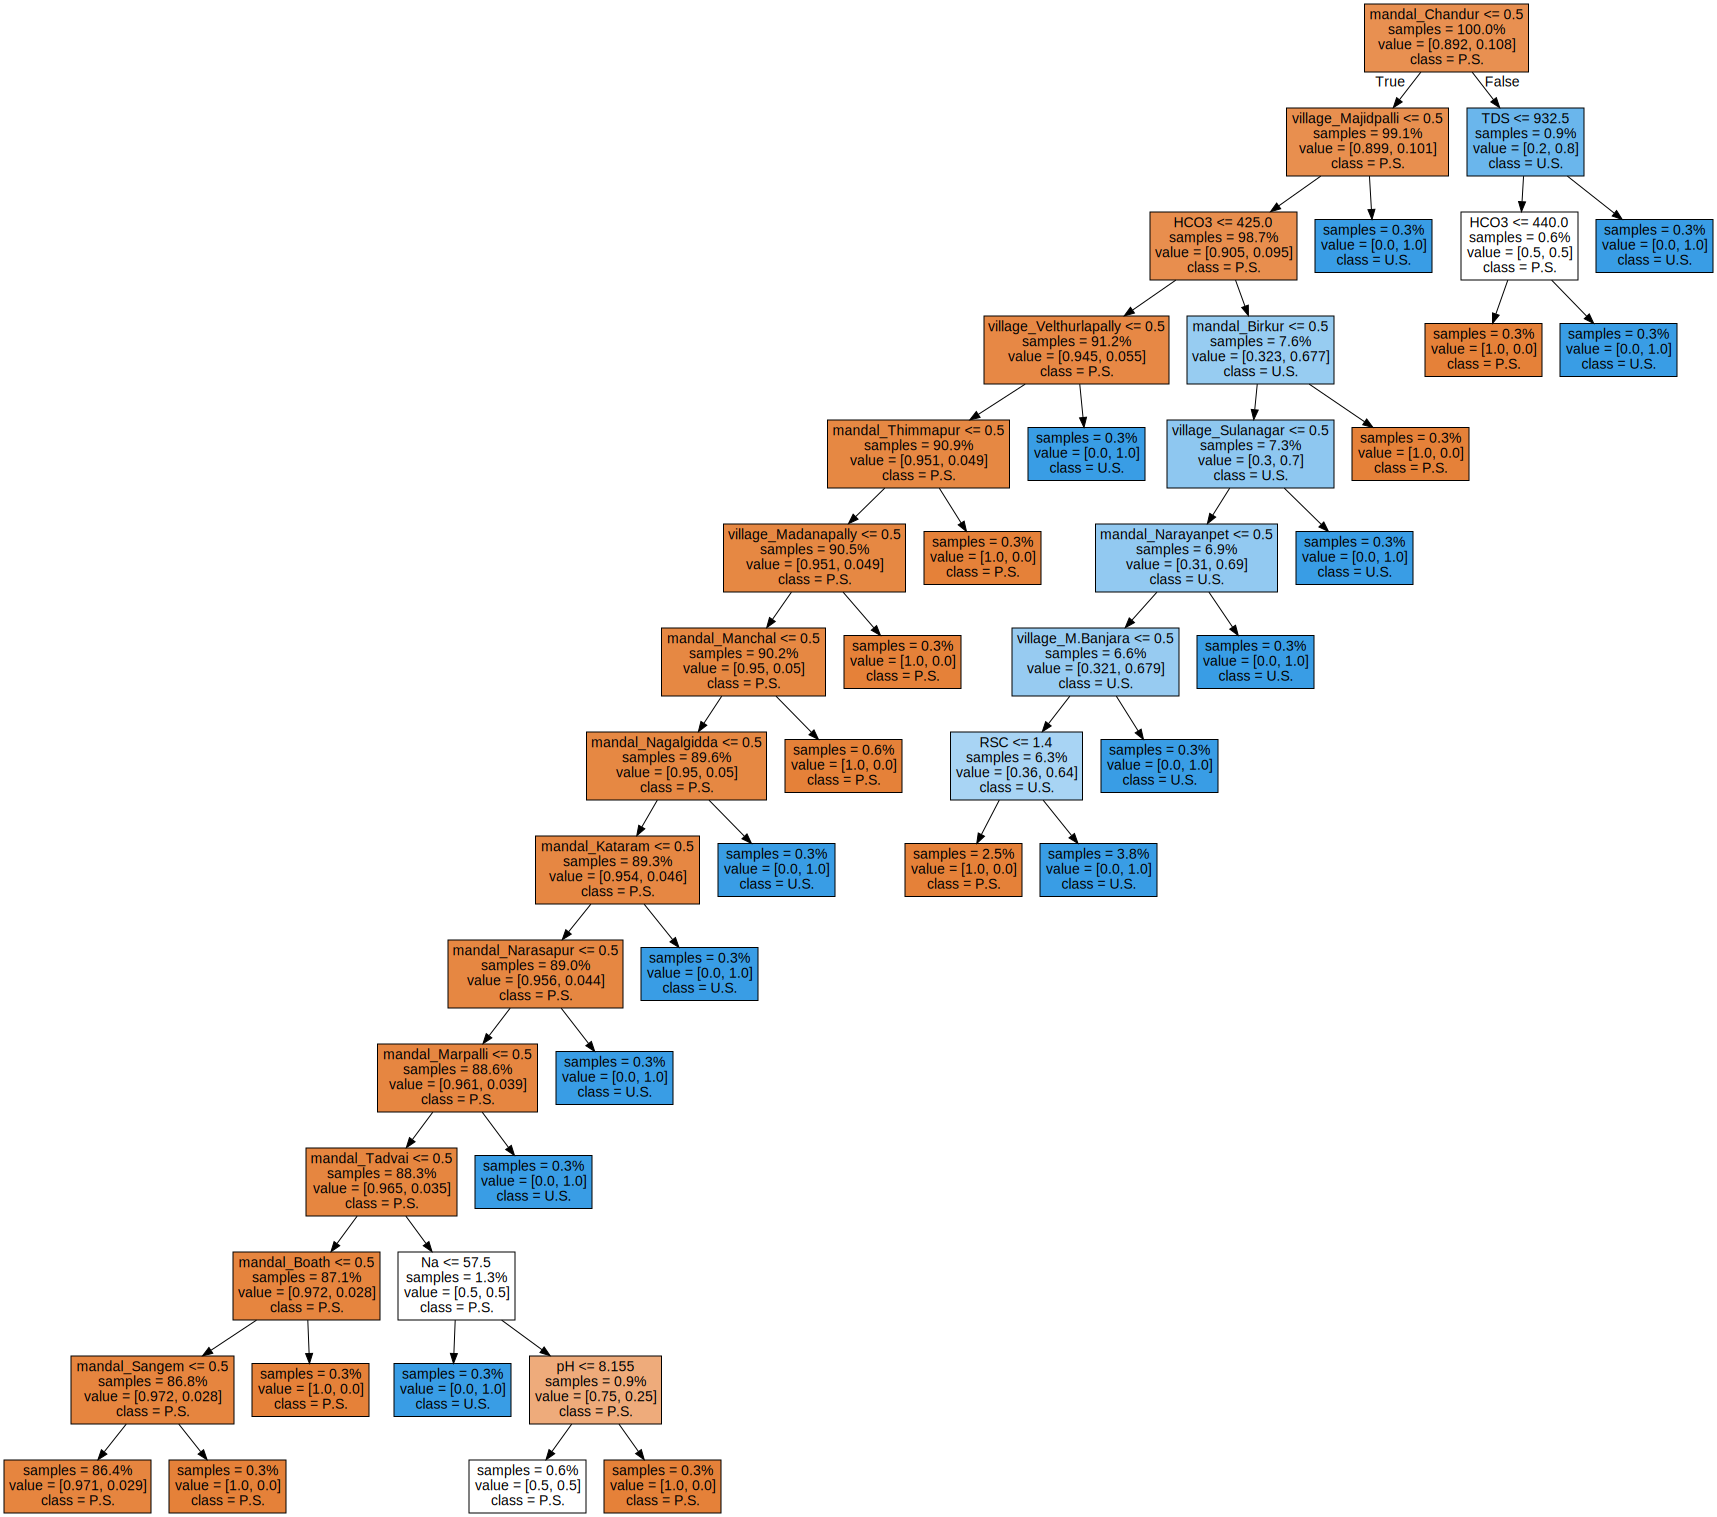

'Random Forest All Features Cross Validated.png'

In [14]:
random.seed(10)
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree, feature_names = X_train.columns, filled = True, max_depth = rand_search.best_params_['max_depth'], impurity = False, proportion = True, class_names = ['P.S.', 'U.S.'])
graph = graphviz.Source(dot_data)
display(graph)
graph.render(f'Random Forest All Features Cross Validated', format='png')

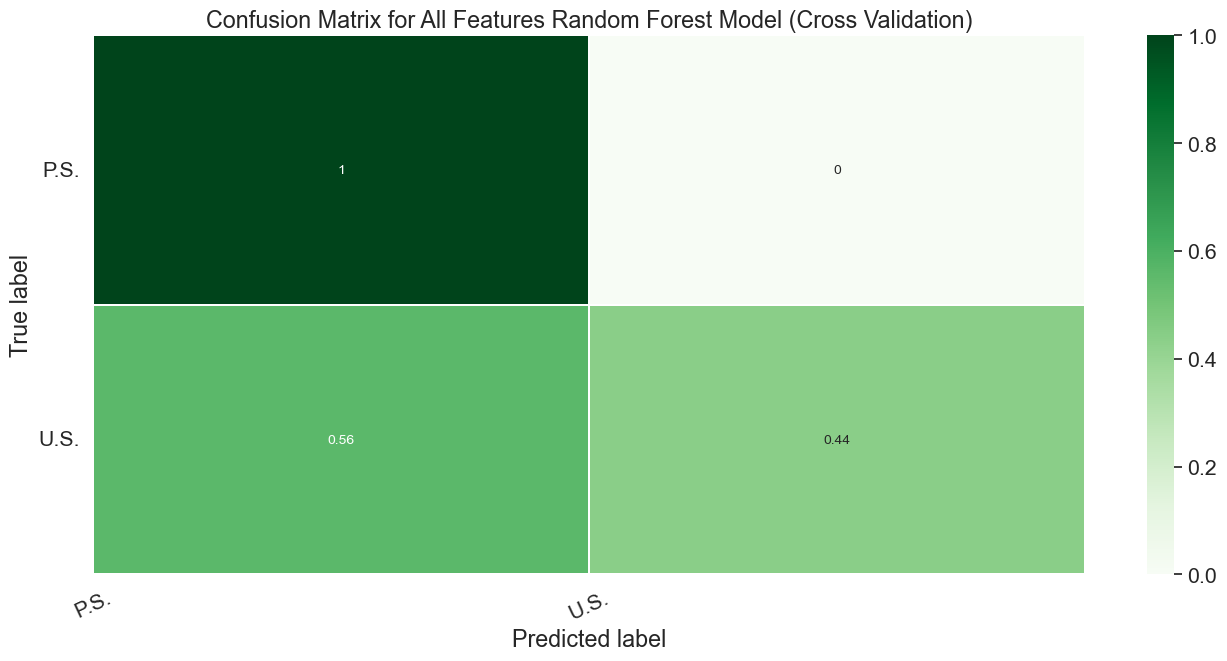

In [15]:
# Confusion Matrix
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis = 1)[:, np.newaxis]

plt.figure(figsize =  (16,7))
sns.set(font_scale = 1.4)
sns.heatmap(matrix, annot=True, annot_kws = {'size':10}, cmap = plt.cm.Greens, linewidths = 0.2)

class_names = ['P.S.', 'U.S.']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for All Features Random Forest Model (Cross Validation)')
plt.savefig('Confusion Matrix for All Features Random Forest Model CV.png')
plt.show()

In [16]:
# Precision, Recall, and F1 Score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        P.S.       0.96      1.00      0.98       302
        U.S.       1.00      0.44      0.61        25

    accuracy                           0.96       327
   macro avg       0.98      0.72      0.79       327
weighted avg       0.96      0.96      0.95       327



### 3. Out of Bag Evaluation All Features

Accuracy: 0.9877675840978594


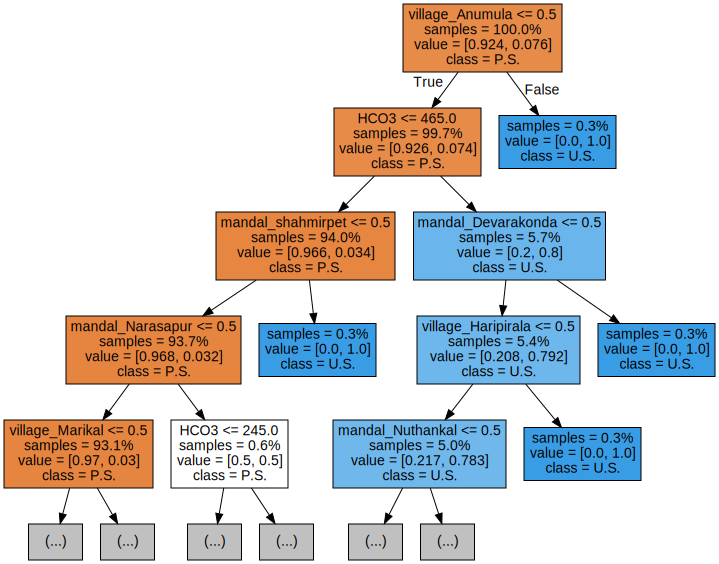

'Random Forest All Features OOB.png'

In [17]:
random.seed(10)
# Splitting Data
X = working_gw_df_encoded.drop('Classification.1', axis = 1)
y = working_gw_df_encoded['Classification.1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

# Random Forest
rf = RandomForestClassifier(oob_score = True, random_state = 10)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# Accuracy Test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree, feature_names = X_train.columns, filled = True, max_depth = 4, impurity = False, proportion = True, class_names = ['P.S.', 'U.S.'])
graph = graphviz.Source(dot_data)
display(graph)
graph.render(f'Random Forest All Features OOB', format='png')

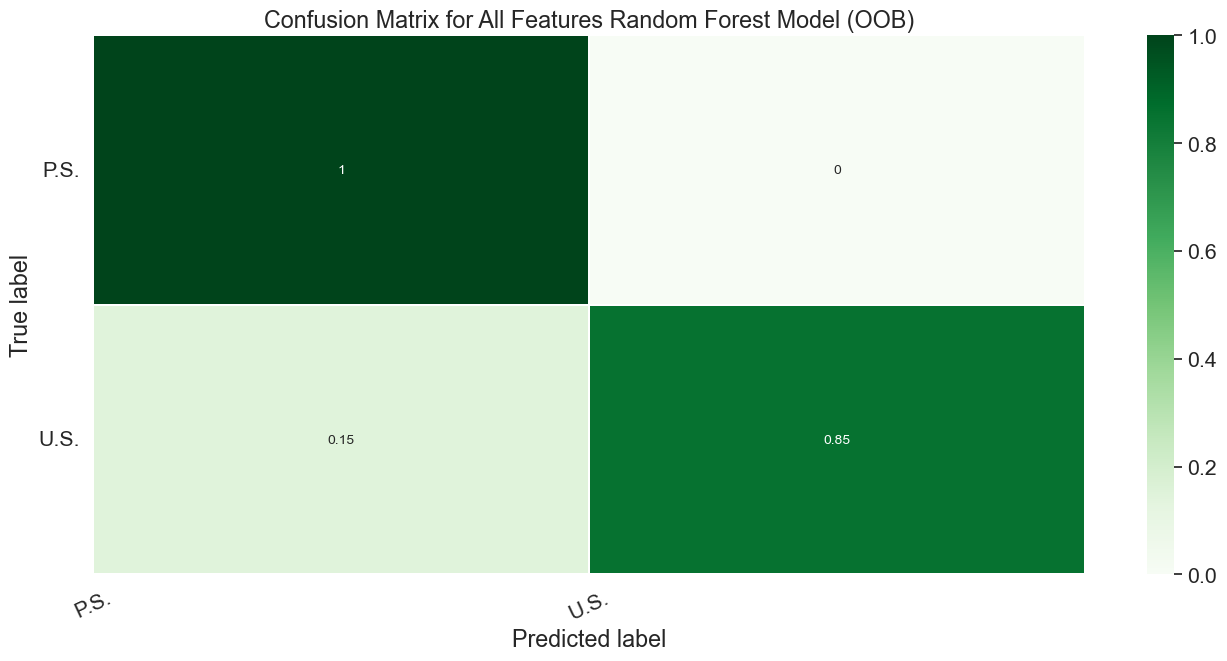

In [18]:
# Confusion Matrix
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis = 1)[:, np.newaxis]

plt.figure(figsize =  (16,7))
sns.set(font_scale = 1.4)
sns.heatmap(matrix, annot=True, annot_kws = {'size':10}, cmap = plt.cm.Greens, linewidths = 0.2)

class_names = ['P.S.', 'U.S.']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for All Features Random Forest Model (OOB)')
plt.savefig('Confusion Matrix for All Features Random Forest Model OOB.png')
plt.show()

In [19]:
# Precision, Recall, and F1 Score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        P.S.       0.99      1.00      0.99       300
        U.S.       1.00      0.85      0.92        27

    accuracy                           0.99       327
   macro avg       0.99      0.93      0.96       327
weighted avg       0.99      0.99      0.99       327



***

## 1. Random Forest with only Numeric Features

Accuracy: 1.0


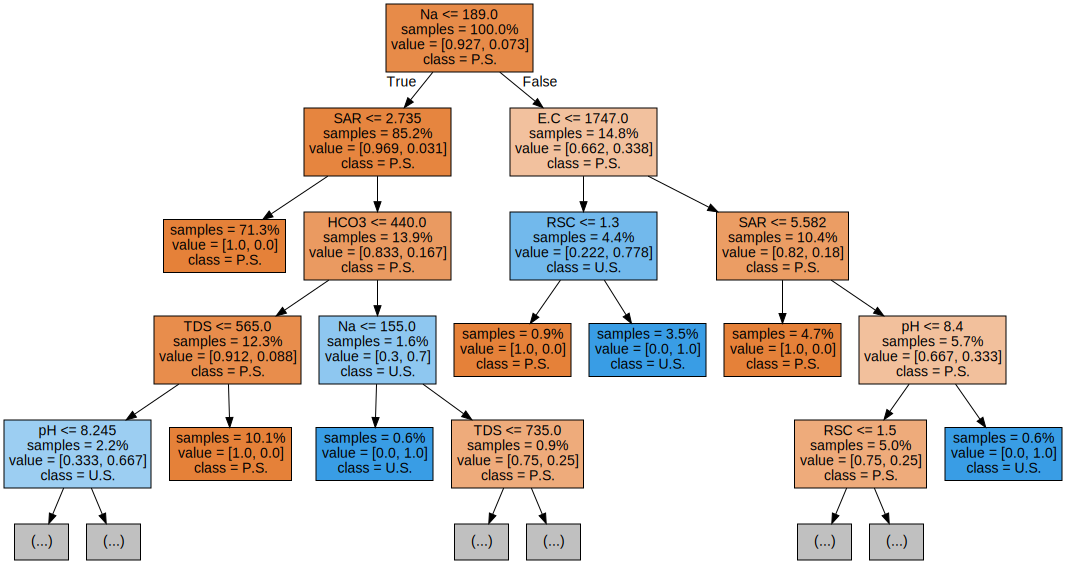

In [20]:
random.seed(10)
# Splitting Data
chosen_numeric = ['RSC', 'SAR', 'Na', 'E.C', 'TDS', 'HCO3', 'pH', 'Classification.1']
X = working_gw_df_encoded[chosen_numeric].drop('Classification.1', axis = 1)
y = working_gw_df_encoded['Classification.1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

# Random Forest
rf = RandomForestClassifier(random_state = 10)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree, feature_names = X_train.columns, filled = True, max_depth = 4, impurity = False, proportion = True, class_names = ['P.S.', 'U.S.'])
graph = graphviz.Source(dot_data)
display(graph)

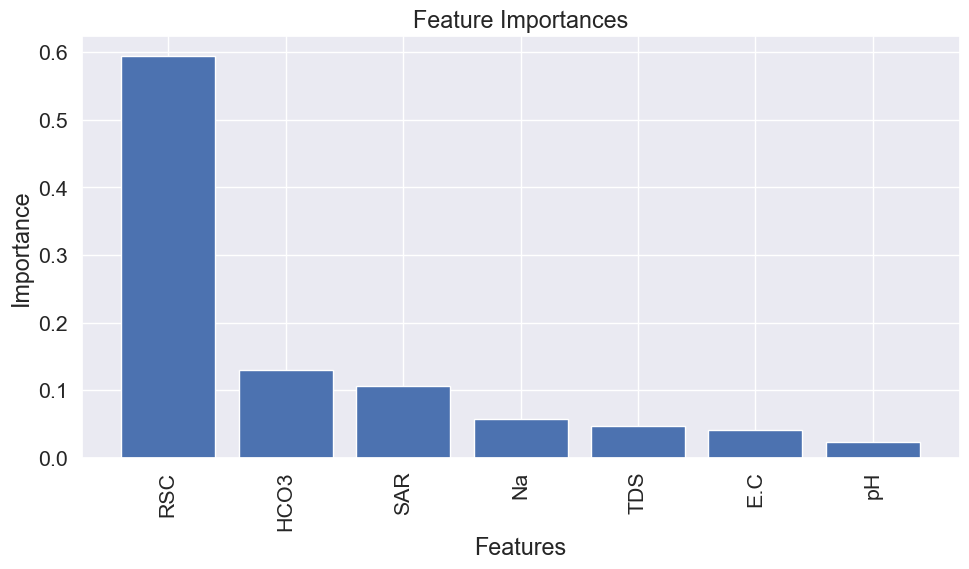

In [21]:
# Aggregate feature importances
importances = rf.feature_importances_

# Sort features by importance
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_features = X_train.columns[sorted_indices]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.savefig('Feature Importance Numeric.png')
plt.show()

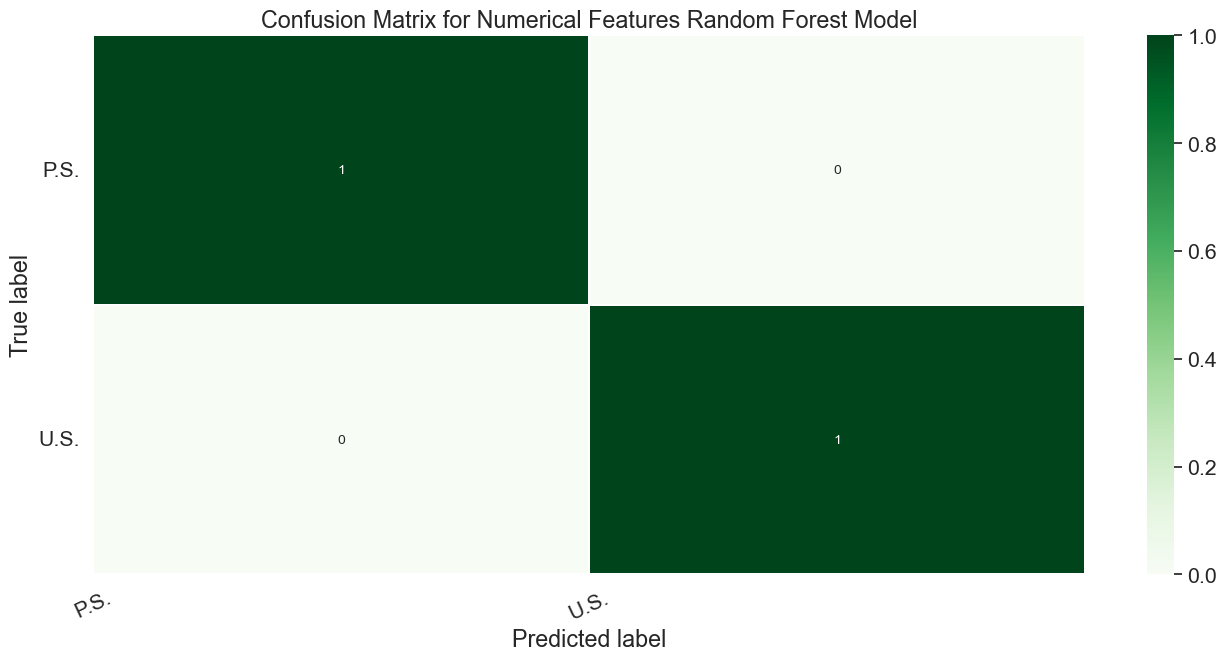

In [22]:
# Confusion Matrix
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis = 1)[:, np.newaxis]

plt.figure(figsize =  (16,7))
sns.set(font_scale = 1.4)
sns.heatmap(matrix, annot=True, annot_kws = {'size':10}, cmap = plt.cm.Greens, linewidths = 0.2)

class_names = ['P.S.', 'U.S.']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Numerical Features Random Forest Model')
plt.savefig('Confusion Matrix for Numerical Features Random Forest Model.png')
plt.show()

In [23]:
# Precision, Recall, and F1 Score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        P.S.       1.00      1.00      1.00       297
        U.S.       1.00      1.00      1.00        30

    accuracy                           1.00       327
   macro avg       1.00      1.00      1.00       327
weighted avg       1.00      1.00      1.00       327



### 2. Cross Validating Best Hyperparameters Numeric Features

In [24]:
random.seed(10)
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier(random_state = 10)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 18, 'n_estimators': 286}


Accuracy: 1.0


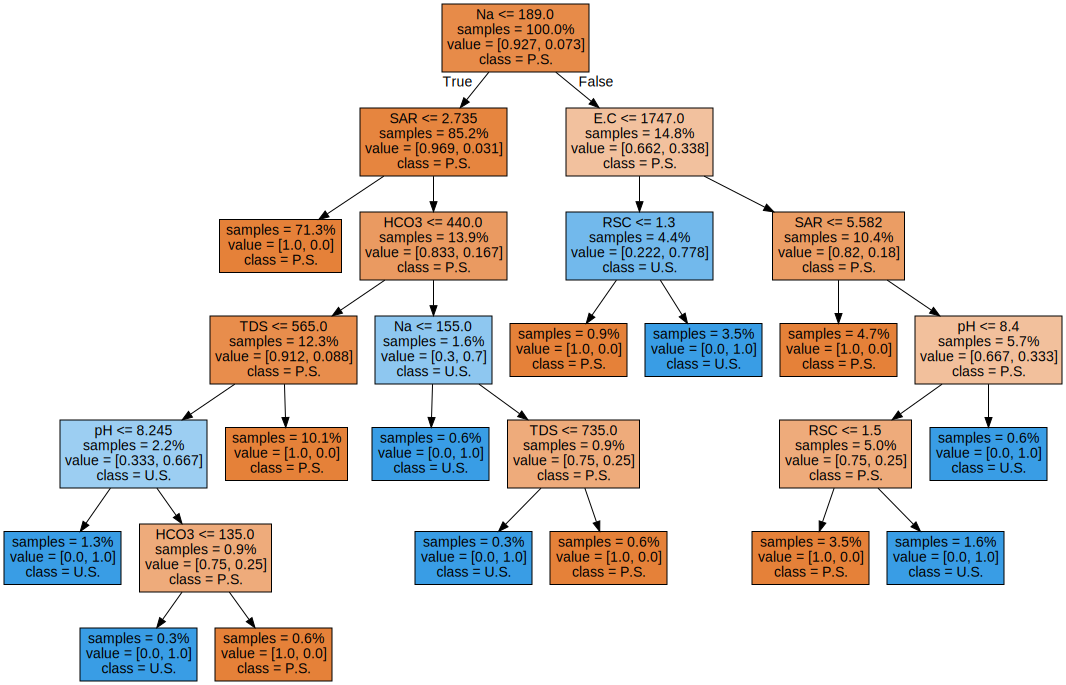

In [25]:
random.seed(10)
# Random Forest
rf = RandomForestClassifier(n_estimators = rand_search.best_params_['n_estimators'], max_depth = rand_search.best_params_['max_depth'], random_state = 10)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# Accuracy Test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree, feature_names = X_train.columns, filled = True, max_depth = rand_search.best_params_['max_depth'], impurity = False, proportion = True, class_names = ['P.S.', 'U.S.'])
graph = graphviz.Source(dot_data)
display(graph)

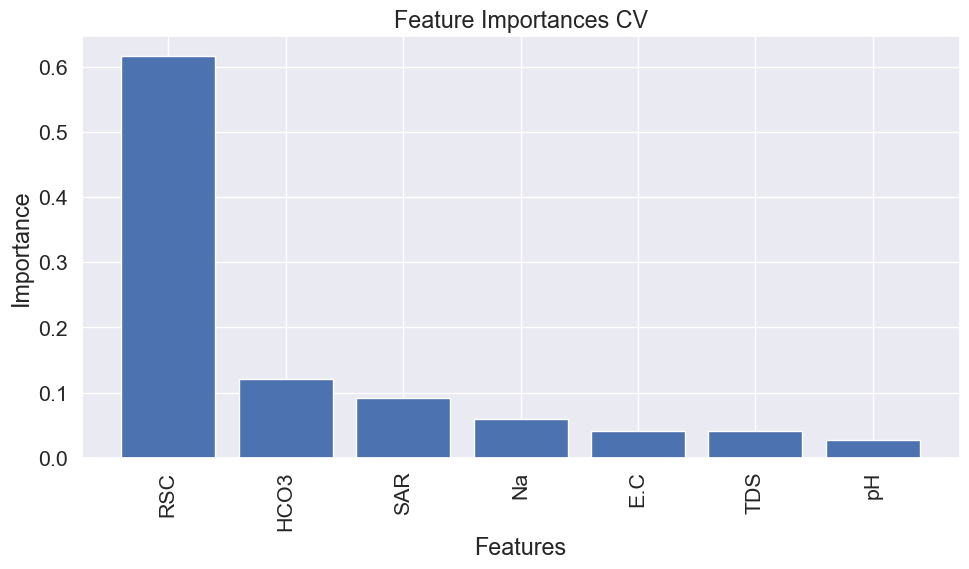

In [26]:
# Aggregate feature importances
importances = np.mean([tree.feature_importances_ for tree in best_rf.estimators_], axis=0)

# Sort features by importance
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_features = X_train.columns[sorted_indices]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances CV')
plt.tight_layout()
plt.savefig('Feature Importances CV.png')
plt.show()

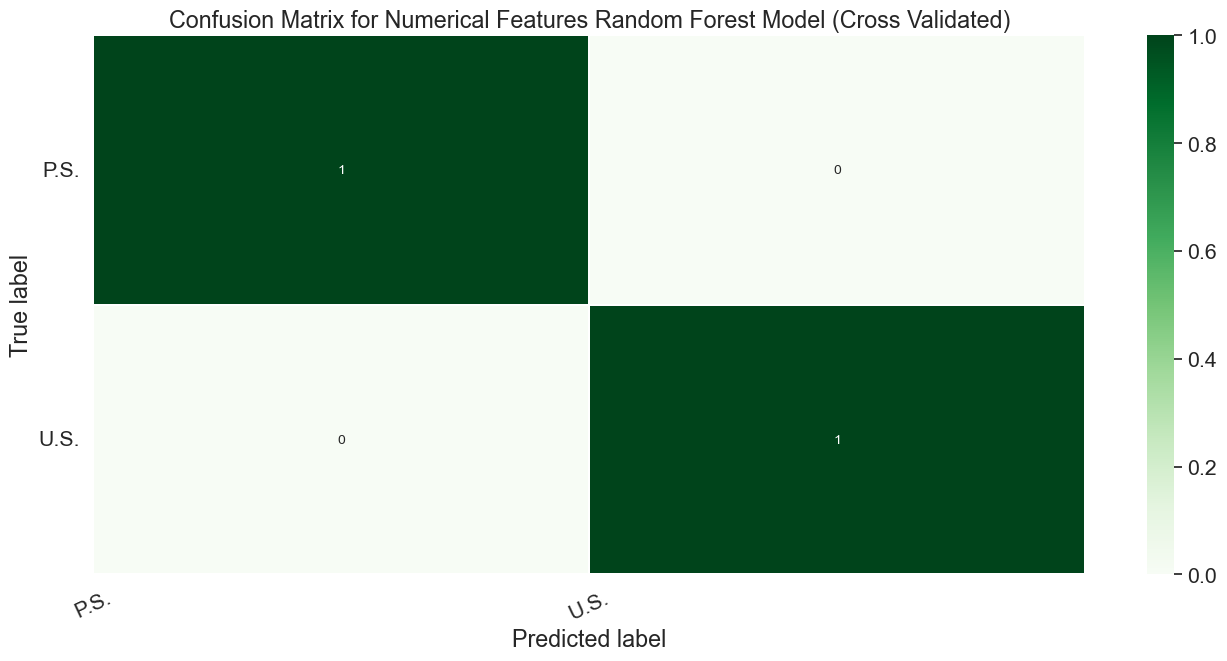

In [27]:
# Confusion Matrix
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis = 1)[:, np.newaxis]

plt.figure(figsize =  (16,7))
sns.set(font_scale = 1.4)
sns.heatmap(matrix, annot=True, annot_kws = {'size':10}, cmap = plt.cm.Greens, linewidths = 0.2)

class_names = ['P.S.', 'U.S.']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Numerical Features Random Forest Model (Cross Validated)')
plt.savefig('Confusion Matrix for Numerical Features Random Forest Model CV.png')
plt.show()

In [28]:
# Precision, Recall, and F1 Score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        P.S.       1.00      1.00      1.00       297
        U.S.       1.00      1.00      1.00        30

    accuracy                           1.00       327
   macro avg       1.00      1.00      1.00       327
weighted avg       1.00      1.00      1.00       327



### 3. Out of Bag Evaluation Numeric Features

Accuracy: 1.0


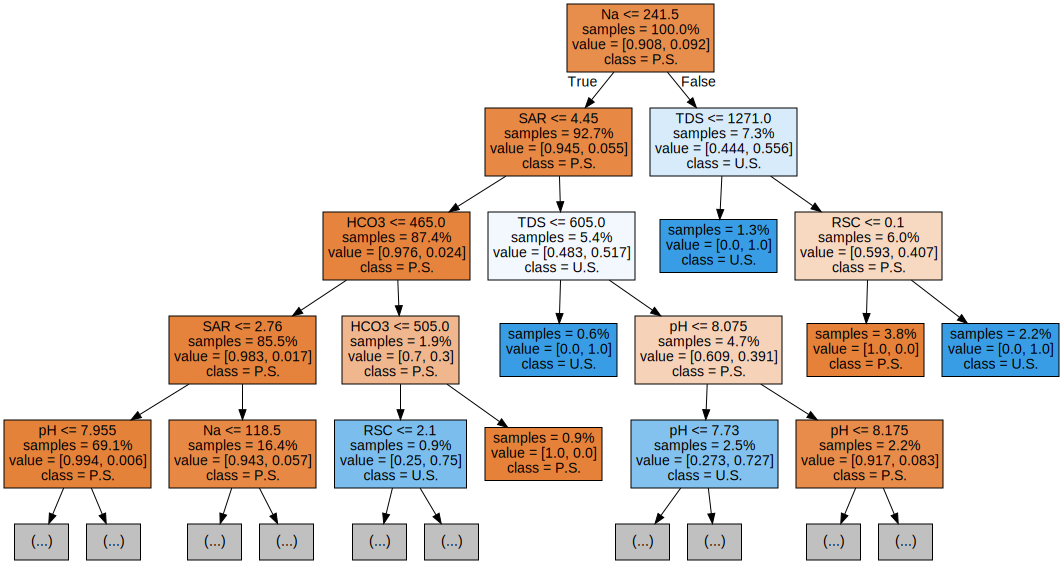

In [29]:
random.seed(10)
chosen_numeric = ['RSC', 'SAR', 'Na', 'E.C', 'TDS', 'HCO3', 'pH', 'Classification.1']
X = working_gw_df_encoded[chosen_numeric].drop('Classification.1', axis = 1)
y = working_gw_df_encoded['Classification.1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

# Random Forest
rf = RandomForestClassifier(oob_score = True, random_state = 10)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree, feature_names = X_train.columns, filled = True, max_depth = 4, impurity = False, proportion = True, class_names = ['P.S.', 'U.S.'])
graph = graphviz.Source(dot_data)
display(graph)

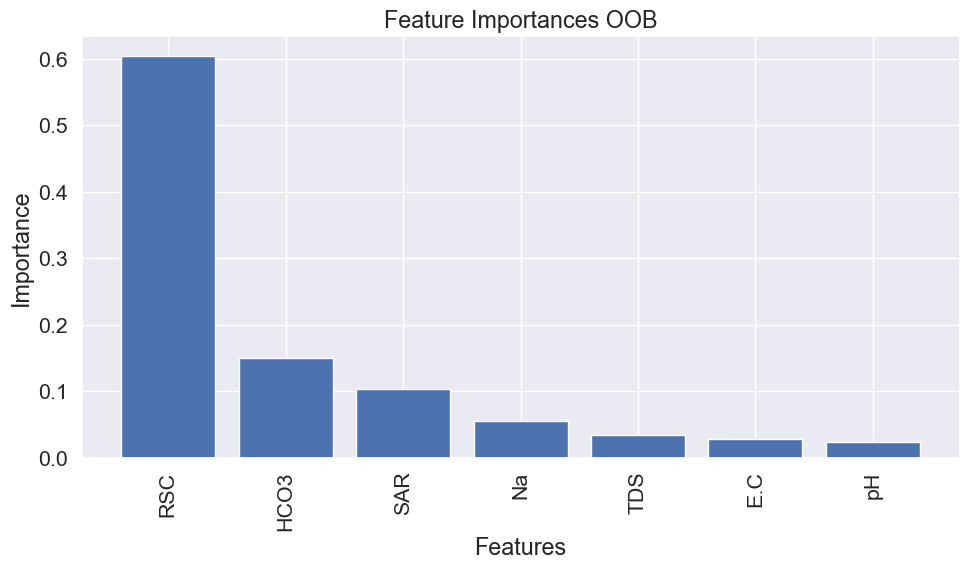

In [30]:
# Aggregate feature importances
importances = rf.feature_importances_

# Sort features by importance
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_features = X_train.columns[sorted_indices]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances OOB')
plt.tight_layout()
plt.savefig('Feature Importances OOB.png')
plt.show()

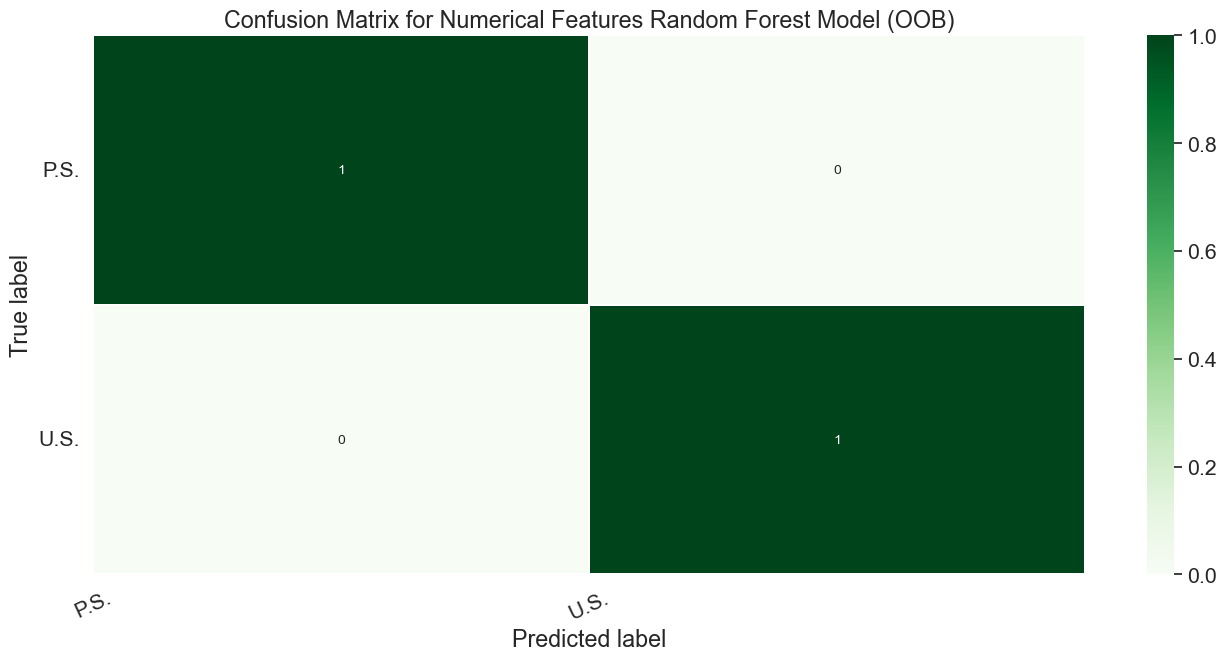

In [31]:
# Confusion Matrix
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis = 1)[:, np.newaxis]

plt.figure(figsize =  (16,7))
sns.set(font_scale = 1.4)
sns.heatmap(matrix, annot=True, annot_kws = {'size':10}, cmap = plt.cm.Greens, linewidths = 0.2)

class_names = ['P.S.', 'U.S.']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Numerical Features Random Forest Model (OOB)')
plt.savefig('Confusion Matrix for Numerical Features Random Forest Model OOB.png')
plt.show()

In [32]:
# Precision, Recall, and F1 Score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        P.S.       1.00      1.00      1.00       299
        U.S.       1.00      1.00      1.00        28

    accuracy                           1.00       327
   macro avg       1.00      1.00      1.00       327
weighted avg       1.00      1.00      1.00       327

